<a href="https://colab.research.google.com/github/kameda-yoshinari/DataAlgo2020/blob/master/DataAlgo2020_005(DFS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.3. 深さ優先探索

ここでは深さ優先探索(Depth first search; DFS)について学ぶ．  
深さ優先探索によって，グラフに即した形で全頂点の列挙を行う．

**いつもの約束**  
１つのコードセルだけの実行は Ctrl + Enter．  
エディタで「インデント幅（スペース）は4で表示」「行番号を表示」「インデントガイドを表示」．  
内部では日本語はUTF-8で表現されている．


# 準備

インスタンスに接続し起動する．  
下記の手順でGoogle Driveをマウントする．  
マウント先に移動し，作業フォルダとする．  
これによって，インスタンスがリセットされてもGoogle Drive内にファイルが保存されるようにする．

In [0]:
!echo "Google Driveをマウントします"
from google.colab import drive 
drive.mount('/content/drive')

In [0]:
!echo "今回の作業用フォルダを作成しそこに移動します"
%cd /content/drive/My\ Drive/202004_DataAlgo
%mkdir -p DA2020_005
%cd DA2020_005
!ls
!echo "日本時間表示"
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Japan /etc/localtime
!date

ここでは，グラフ3を利用する．  
頂点数は8．無向グラフ．連結．

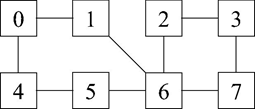

In [0]:
%%writefile graph3.h
// 8 nodes, undirected, no-weight.
#define N 8
int edge[N][N] = {
//   0 1 2 3 4 5 6 7
	{0,1,0,0,1,0,0,0}, // 0
	{1,0,0,0,0,0,1,0}, // 1
	{0,0,0,1,0,0,1,0}, // 2
	{0,0,1,0,0,0,0,1}, // 3
	{1,0,0,0,0,1,0,0}, // 4
 	{0,0,0,0,1,0,1,0}, // 5
	{0,1,1,0,0,1,0,1}, // 6
	{0,0,0,1,0,0,1,0}  // 7
};

# 深さ優先探索の概要

Rogueのようなダンジョン型RPGにおいて，最初の部屋（開始頂点）から見てできるだけ遠い部屋から制圧していくのが深さ優先探索である．大胆な戦略とも言える．

より正確には，開始頂点からの道が長い頂点から先に列挙していく探索が深さ優先探索である．ここで，全ての辺は同じ長さを持つとする．（道において同一頂点は高々１回しか現れないことに注意．）

深さ優先探索のアルゴリズムの記述においては，スタック(First-In-Last-Out = Last-In-First-Out)を利用する．大雑把に言えば，開始頂点から見てできるだけ遠いch頂点から調査を行って列挙していく．このとき，その頂点に隣接している未列挙頂点があれば，それをすぐ次に調査する．つまり最後に見つかった頂点から調査することになる(Last-In-First-Out)．これをスタックに積むという．ある頂点からさらに先に（遠くに）頂点が見つからない場合，頂点を一つ戻って（スタックの一番を取り去って，そこに現れるひとつ前の）頂点の調査を続行する．

グラフに閉路がある場合，開始頂点からある頂点への道が２つ以上あることがある．最初に到達するのに用いた道より次に到達するのに使った道がより短い，ということが起きうる．最初に到達した時点で当該頂点が開始頂点から見て一番遠い頂点だった場合，（後でそれほど遠い頂点でないとわかることになるにしても）その時点で列挙することは深さ優先探索の定義に合致する．（あとでより短い道が見つかったとしても列挙順を訂正したりはしない．）

参考までに，グラフG3について頂点0からDFSを実施した場合，深さ優先による頂点列挙の結果は次のようになる．  
ただし，同じ優先度の頂点が複数あったときは，番号の小さい方の頂点を選択するものとする．

DFS result: 0 1 6 2 3 7 5 4

# 深さ優先探索プログラム

**目標**

スタックを用いた深さ優先探索によって，与えられたグラフの頂点を列挙する．

**説明**

開始頂点は指定されるものとする．  
  
スタックは机の上に積んでいく宿題だと思えばよい．   
スタックの一番上を stacktop と呼ぶことにする．    
新しくオブジェクトを追加するときは，それをスタックの一番上に積む．  
（宿題を上に積み重ねるのと同じことである．）  
積み上げる動作のことを push と呼ぶ．  
詰み上がった一番上のオブジェクトを取り去る動作のことを pop と呼ぶ．  
（一番上の宿題を取って，自分の前に拡げるのと同じことである）  

**コード**

下記の通り．  
グラフが無向で連結である限り，深さ優先探索は必ず成功する．  
そのため，dfs()はvoidとしている．

**備考**

なし．

In [0]:
%%writefile dfs_simple_J.c
// Depth First Search.
// 2020/05 kameda[at]ccs.tsukuba.ac.jp
#include <stdio.h> // printf()
#include "graph3.h"

// 深さ優先探索本体
void dfs(int StartingRoom){
	int listed[N];  // 0 未, 1 済
	int stack[N];
	int stacktop = 0;
    
	int CurrentRoom;
	int RoomToCheck;

	int visited[N]; // 列挙順を記録するための配列
	int num_visited = 0; // 記録済の頂点数

	for (RoomToCheck = 0; RoomToCheck < N; RoomToCheck++)
		listed[RoomToCheck] = 0;
	
	printf("深さ優先探索を 頂点%d から開始します．\n", StartingRoom);
	// StartingRoomをスタックに積む
	stack[stacktop] = StartingRoom;
	stacktop++;

	// スタックに処理対象がある限り作業を継続
	while (stacktop > 0) {
		printf("現在のスタック： 長さ %d, スタックトップは %d\n", stacktop, stack[stacktop - 1]);
		{int i; for (i = 0; i < stacktop; i++) printf("%d ", stack[i]); printf("\n");}

		// スタックから１つ降ろして処理開始（スタックからは削除）
		printf("スタックトップの頂点 %d をスタックから降ろして処理を開始します．\n", stack[stacktop - 1]);
		CurrentRoom = stack[stacktop - 1];
		stacktop--;

		// ※ここで何かしらの作業を行うのかも．

		// 処理済みであることを記録
		printf("頂点 %d をこれ以降は列挙済として扱います．\n", CurrentRoom);
		listed[CurrentRoom] = 1;
		// 計上（列挙）順を記録
		visited[num_visited] = CurrentRoom;
		num_visited++;

		// 次にどの頂点を列挙していくか検討
		//   次のfor文の変数が降順（小さくしていく）になっているのは
		//  「同じ優先度の頂点が複数あったときは，番号の小さい方の頂点を選択」を遵守するため
		for (RoomToCheck = N-1; RoomToCheck >= 0; RoomToCheck--) {
   	        if (edge[CurrentRoom][RoomToCheck] == 0) {
				printf("  (頂点 %d にて) 頂点 %d は隣接していませんでした‥\n", CurrentRoom, RoomToCheck);
			} else if (listed[RoomToCheck] != 0) {
				printf("  (頂点 %d にて) 頂点 %d は隣接はしていますがすでに処理済でした‥\n", CurrentRoom, RoomToCheck);
			} else {         
				printf("  (頂点 %d にて) まだ処理したことのない頂点 %d が隣接しているので、スタックに積み上げます．\n", CurrentRoom, RoomToCheck);
               	// RoomToCheckをスタックに積む
				stack[stacktop] = RoomToCheck;
               	stacktop++;
			}
		}
	}
	printf("処理待ち行列に何も残っていないので深さ優先探索を終了します．\n");

	printf("深さ優先探索による頂点の列挙．\n");
	for (CurrentRoom = 0; CurrentRoom < N; CurrentRoom++)
		printf("%d ", visited[CurrentRoom]);
	printf("\n");

	return;
}

int main(int argc, char *argv[]){
	dfs(0); // 開始頂点番号を引数にしてdfs関数を呼び出す
	return 0;
}

コンパイルしてエラーが無いことを確認．

In [0]:
!gcc -Wall -o dfs_simple_J dfs_simple_J.c

実行．

In [0]:
!./dfs_simple_J

# 拡張（引数の利用）

**目標**

引数にて開始頂点を指定できるようにする．  

**説明**

引数を数値にするためにはatoi()関数を用いる．  
（atoi()関数ではエラーハンドリングができないため，エラーハンドリングができるstrtol()関数のほうが頑健なプログラム作成には望ましい．  ）


**コード**

次はatoi()関数を引数の解釈に用いる例である．   
main()関数内で引数の確認を行っている．  

**備考**

dfs()関数部分には変更を加えていない．  



In [0]:
%%writefile dfs_xtraCommandLine_J.c
// Depth First Search.
// 2020/05 kameda[at]ccs.tsukuba.ac.jp
// -- Extra --
//    Accept command line option
#include <stdio.h> // printf()
#include <stdlib.h> // atoi()
#include "graph3.h"

// 深さ優先探索本体
void dfs(int StartingRoom){
	int listed[N];  // 0 未, 1 済
	int stack[N];
	int stacktop = 0;

	int CurrentRoom;
	int RoomToCheck;

	int visited[N]; // 列挙順を記録するための配列
	int num_visited = 0; // 記録済の頂点数

	for (RoomToCheck = 0; RoomToCheck < N; RoomToCheck++)
		listed[RoomToCheck] = 0;
	
	printf("深さ優先探索を 頂点%d から開始します．\n", StartingRoom);
	// StartingRoomをスタックに積む
	stack[stacktop] = StartingRoom;
	stacktop++;

	// スタックに処理対象がある限り作業を継続
	while (stacktop > 0) {
		printf("現在のスタック： 長さ %d, スタックトップは %d\n", stacktop, stack[stacktop - 1]);
		{int i; for (i = 0; i < stacktop; i++) printf("%d ", stack[i]); printf("\n");}

    	// スタックから１つ降ろして処理開始（スタックからは削除）
		printf("スタックトップの頂点 %d をスタックから降ろして処理を開始します．\n", stack[stacktop - 1]);
		CurrentRoom = stack[stacktop - 1];
		stacktop--;

		// ※ここで何かしらの作業を行うのかも．

		// 処理済みであることを記録
		printf("頂点 %d をこれ以降は列挙済として扱います．\n", CurrentRoom);
		listed[CurrentRoom] = 1;
		// 計上（列挙）順を記録
		visited[num_visited] = CurrentRoom;
		num_visited++;

		// 次にどの頂点を列挙していくか検討
		for (RoomToCheck = N-1; RoomToCheck >= 0; RoomToCheck--) {
			if (edge[CurrentRoom][RoomToCheck] == 0) {
				printf("  (頂点 %d にて) 頂点 %d は隣接していませんでした‥\n", CurrentRoom, RoomToCheck);
			} else if (listed[RoomToCheck] != 0) {
				printf("  (頂点 %d にて) 頂点 %d は隣接はしていますがすでに処理済でした‥\n", CurrentRoom, RoomToCheck);
			} else {         
				printf("  (頂点 %d にて) まだ処理したことのない頂点 %d が隣接しているので、スタックに積み上げます．\n", CurrentRoom, RoomToCheck);
				// RoomToCheckをスタックに積む
				stack[stacktop] = RoomToCheck;
				stacktop++;
			}
		}
	}
	printf("処理待ち行列に何も残っていないので深さ優先探索を終了します．\n");

	printf("深さ優先探索による頂点の列挙．\n");
	for (CurrentRoom = 0; CurrentRoom < N; CurrentRoom++)
		printf("%d ", visited[CurrentRoom]);
    printf("\n");

	return;
}

int main(int argc, char *argv[]){
	int startnode = 0;
	if (argc == 1) {
		printf("指定がなかったので頂点0を開始頂点にします．\n");
		startnode = 0;
	} else if (argc == 2) {
		startnode = atoi(argv[1]);
		if (startnode < 0 || startnode >= N) {
			printf("不正な頂点指定だったので終了します．\n");
			return -1;
		}
	}

	dfs(startnode); // 開始頂点番号を引数にしてdfs関数を呼び出す
	return 0;
}

コンパイルしてエラーが無いことを確認．

In [0]:
!gcc -Wall -o dfs_xtraCommandLine_J dfs_xtraCommandLine_J.c

実行．

In [0]:
!./dfs_xtraCommandLine_J 0

# 拡張（関数の利用）

**目標**

スタックへ積み上げることと，スタックから降ろすことを，それぞれユーザ定義関数化する．

**説明**

ユーザ定義関数は別ソースファイルに記述する．  
これによって，将来ライブラリにすることができる．

**コード**

３つのファイルに分割する．
* スタック操作のヘッダファイル
* スタック操作を集めたソースファイル
* 深さ優先探索を行うプログラム

**備考**

分割コンパイルで実行ファイルを生成する．

In [0]:
%%writefile StackLib_J.h
// Stack management
// 2020/05 kameda[at]ccs.tsukuba.ac.jp

// スタックの初期化
int *initstack(int );

// スタックへの追加
int stackpush(int );

// スタックからの削除
int stackpop(void);

// スタックの状態表示
int showstack(void);

// スタックの全表示（通常意味はない）
int showallstack(void);


In [0]:
%%writefile StackLib_J.c
// Stack management
// 2020/05 kameda[at]ccs.tsukuba.ac.jp
#include <stdio.h> // printf()
#include <stdlib.h> // calloc()
#include "StackLib_J.h" // プロトタイプ宣言の整合確認

int *stack = NULL; // スタックの本体（初期化してから使う）
int stacksize = 0; // スタックのサイズ
int stacktop = 0; // スタックトップ

// スタックの初期化
int *initstack(int n) {
    stack = calloc(n, sizeof(*stack));
    if (stack == NULL) {
        printf("【失敗】 %d要素分のスタック領域を確保できませんでした．\n", n);
    }
    stacksize = n;
    return stack;
}

// スタックへの追加
int stackpush(int v) {
    if (stack == NULL) {
        printf("【失敗】 スタックが用意できていません．\n");
        return -1;
    } else if (stacktop >= stacksize) {
        printf("【失敗】 %d要素確保してあったスタック領域を使い果たしてしまいました．\n", stacksize);
        return -2;
    }
    stack[stacktop] = v;
    stacktop++;
    return 0;
}

// スタックからの削除
int stackpop(void) {
    int v;
    if (stack == NULL) {
        printf("【失敗】 スタックが用意できていません．\n");
        return -1;
    } else if (stacktop <= 0) {
        printf("【報告】 スタックに処理対象がありません．\n");
        return -2;
    }
    v = stack[stacktop - 1];
    stacktop--;
    return v;
}

// スタックの状態表示
int showstack(void) {
    int i;

    if (stack == NULL) {
        printf("【失敗】 スタックが用意できていません．\n");
        return -1;
    }

    printf("stacksize = %d, stacktop = %d\n", stacksize, stacktop);
    for (i = 0; i < stacktop; i++) {
        printf("%d ", stack[i]);
    }
    printf("\n");

    return stacktop;
}

// スタックの全表示（通常意味はない）
int showallstack(void) {
    int i;

    if (stack == NULL) {
        printf("【失敗】 スタックが用意できていません．\n");
        return -1;
    }

    printf("stacksize = %d, stacktop = %d\n", stacksize, stacktop);
    for (i = 0; i < stacksize; i++) {
        printf("%d ", stack[i]);
    }
    printf("\n");

    return stacksize;
}



分割したスタック関係のソースファイルのみコンパイル．  
（ライブラリの作成に相当）

In [0]:
!gcc -Wall -c StackLib_J.c

スタック関係の関数は外部のを用いるので，それに合わせて書き直す．   
"StackLib_J.h"の内容のみ参照して書き直せればよい．   
（この辺りの内容はプログラミング序論Dで学習済み）  

外部関数等を使いながらmain()関数などを書く場合，ユーザプログラムと呼ぶことがある．  

In [0]:
%%writefile dfs_xtraFuncCalls_J.c
// Depth First Search.
// 2020/05 kameda[at]ccs.tsukuba.ac.jp
// -- Extra --
//    Accept command line option
//    Call functions for stackpush and stackpop
#include <stdio.h> // printf()
#include <stdlib.h> // atoi()
#include "StackLib_J.h"
#include "graph3.h"

// 深さ優先探索本体
void dfs(int StartingRoom){
	int listed[N];  // 0 未, 1 済
    
    int CurrentRoom;
    int RoomToCheck;

	int visited[N]; // 列挙順を記録するための配列
	int num_visited = 0; // 記録済の頂点数

	for (RoomToCheck = 0; RoomToCheck < N; RoomToCheck++)
		listed[RoomToCheck] = 0;

    // スタックの初期化
    initstack(N);
	
	printf("深さ優先探索を 頂点%d から開始します．\n", StartingRoom);
    // StartingRoomをスタックに積む
    stackpush(StartingRoom);

    // スタックの状態表示
    // while()文のところでスタック操作が行われるため，その直前状態を表示するため表示タイミングを移動
    showstack();

	// スタックに処理対象がある限り作業を継続
	while ((CurrentRoom = stackpop()) >= 0) {
        // スタックから１つ降ろして処理開始（スタックからは削除）
		printf("スタックトップの頂点 %d をスタックから降ろして処理を開始します．\n", CurrentRoom);

		// ※ここで何かしらの作業を行うのかも．

		// 処理済みであることを記録
		printf("頂点 %d をこれ以降は列挙済として扱います．\n", CurrentRoom);
		listed[CurrentRoom] = 1;
		// 計上（列挙）順を記録
		visited[num_visited] = CurrentRoom;
		num_visited++;

        // 次にどの頂点を列挙していくか検討
		for (RoomToCheck = N-1; RoomToCheck >= 0; RoomToCheck--) {
   	        if (edge[CurrentRoom][RoomToCheck] == 0) {
				printf("  (頂点 %d にて) 頂点 %d は隣接していませんでした‥\n", CurrentRoom, RoomToCheck);
			} else if (listed[RoomToCheck] != 0) {
				printf("  (頂点 %d にて) 頂点 %d は隣接はしていますがすでに処理済でした‥\n", CurrentRoom, RoomToCheck);
        	} else {         
				printf("  (頂点 %d にて) まだ処理したことのない頂点 %d が隣接しているので、スタックに積み上げます．\n", CurrentRoom, RoomToCheck);
               	// RoomToCheckをスタックに積む
				stackpush(RoomToCheck);
			}
		}
	    // スタックの状態表示
    	// while()文のところでスタック操作が行われるため，その直前状態を表示するため表示タイミングを移動
        showstack();
	}
	printf("何も残っていないので深さ優先探索を終了します．\n");

	printf("深さ優先探索による頂点の列挙．\n");
	for (CurrentRoom = 0; CurrentRoom < N; CurrentRoom++)
		printf("%d ", visited[CurrentRoom]);
    printf("\n");

	return;
}

int main(int argc, char *argv[]){
    int startnode = 0;
    if (argc == 1) {
        printf("指定がなかったので頂点0を開始頂点にします．\n");
        startnode = 0;
    } else if (argc == 2) {
        startnode = atoi(argv[1]);
        if (startnode < 0 || startnode >= N) {
            printf("不正な頂点指定だったので終了します．\n");
            return -1;
        }
    }

	dfs(startnode); // 開始頂点番号を引数にしてdfs関数を呼び出す
	return 0;
}

ユーザプログラムのコンパイル（のみ）．

In [0]:
!gcc -Wall -c dfs_xtraFuncCalls_J.c

リンカを実行して，実行ファイルを作成．

In [0]:
!gcc -o dfs_xtraFuncCalls_J dfs_xtraFuncCalls_J.o StackLib_J.o

実行．

In [0]:
!./dfs_xtraFuncCalls_J 0

# 拡張（再帰呼出の利用）

**目標**

C言語の再帰呼出を利用することで深さ優先探索を実現する．


**説明**

C言語には，スタックを利用した言語構造がある．  
それは関数呼び出しである．  
C言語では，関数を呼び出すとき，その引数と内部変数はスタック領域に確保される．  
再帰呼出関数を利用してプログラムを書くことで，スタック操作を明示的に行わないまま深さ優先探索が実現できる．  

C言語特有の言語構造を利用することで，ユーザプログラムの記述が簡素になっていることに注意すること．  

なお，C言語特有の言語構造にキューはないので，幅優先探索をこれと同じような形で簡素に記述することはできない．

**コード**

再帰呼出中にも利用するため，listed[] と visited[] を大域変数として確保する．  
大域変数の初期化は main() 関数で行う．  
深さ優先探索の結果である列挙の表示も main() 関数で行う．  

**備考**

例えば，日本語では２人称を表す単語に，あなた，おまえ，貴様，など幾つかある．  
英語では２人称を表す単語はyouだけである．  
愛を込めて相手を呼ぶとき，日本語なら「あなた」だけで含意することができるが，英語では "my sweet honey"のように言い換えたり単語数を増やすことが必要になる．  
C言語はプログラミング言語であり人工言語ではあるが，やはり言語ではあるので，似たようなことが生じるのである．

In [0]:
%%writefile dfs_recursive_J.c
// Depth First Search by recursive call
// 2020/05 kameda[at]ccs.tsukuba.ac.jp
#include <stdio.h> // printf()
#include <stdlib.h> // atoi()
#include "graph3.h"

int listed[N];  // 0 未, 1 済

int visited[N]; // 列挙順を記録するための配列
int num_visited = 0; // 記録済の頂点数


// 深さ優先探索本体 / 再帰呼出
void dfs(int CurrentRoom){
    int RoomToCheck;

    // スタック領域に積み上がった状態で処理開始
	printf("頂点 %d について処理を開始します．\n", CurrentRoom);

	// ※ここで何かしらの作業を行うのかも．

	// 処理済みであることを記録
	printf("頂点 %d をこれ以降は列挙済として扱います．\n", CurrentRoom);
	listed[CurrentRoom] = 1;
	// 計上（列挙）順を記録
	visited[num_visited] = CurrentRoom;
	num_visited++;

    // 次にどの頂点を列挙していくか検討
	for (RoomToCheck = 0; RoomToCheck < N; RoomToCheck++) {
        if (edge[CurrentRoom][RoomToCheck] == 0) {
			printf("  (頂点 %d にて) 頂点 %d は隣接していませんでした‥\n", CurrentRoom, RoomToCheck);
		} else if (listed[RoomToCheck] != 0) {
			printf("  (頂点 %d にて) 頂点 %d は隣接はしていますがすでに処理済でした‥\n", CurrentRoom, RoomToCheck);
       	} else {         
			printf("  (頂点 %d にて) まだ処理したことのない頂点 %d が隣接しているので、すぐに取り掛かります．\n", CurrentRoom, RoomToCheck);
           	// RoomToCheckの処理へ進む（再帰呼出）
			dfs(RoomToCheck);
		}
	}
	return;
}

int main(int argc, char *argv[]){
    int RoomToCheck;

    int startnode = 0;
    if (argc == 1) {
        printf("指定がなかったので頂点0を開始頂点にします．\n");
        startnode = 0;
    } else if (argc == 2) {
        startnode = atoi(argv[1]);
        if (startnode < 0 || startnode >= N) {
            printf("不正な頂点指定だったので終了します．\n");
            return -1;
        }
    }

	for (RoomToCheck = 0; RoomToCheck < N; RoomToCheck++)
		listed[RoomToCheck] = 0;

	dfs(startnode); // 開始頂点番号を引数にしてdfs関数を呼び出す

   	printf("深さ優先探索による頂点の列挙．\n");
	for (RoomToCheck = 0; RoomToCheck < N; RoomToCheck++)
		printf("%d ", visited[RoomToCheck]);
    printf("\n");

	return 0;
}


コンパイルしてエラーが無いことを確認．

In [0]:
!gcc -Wall -o dfs_recursive_J dfs_recursive_J.c

実行．

In [0]:
!./dfs_recursive_J

# 再帰呼出の利用による最小構成

前のプログラムは実行が確認しやすいように各部にprintf()を挿入していたが，実行に必要な部分のみでdfs()関数を構成すると次のようになる．再帰呼出の他は代入文１行，printf文１行，for文１行，if文１行しかない．

如何にプログラムが簡潔に書けるかがよくわかるであろう．

In [0]:
%%writefile dfs_recursive-short_J.c
// Depth First Search by recursive call
// 2020/05 kameda[at]ccs.tsukuba.ac.jp
#include <stdio.h> // printf()
#include <stdlib.h> // atoi()
#include "graph3.h"

int listed[N];  // 0 未, 1 済

// 深さ優先探索本体 / 再帰呼出
void dfs(int CurrentRoom){
    int RoomToCheck;

	// 処理済みであることを記録
	listed[CurrentRoom] = 1;
	// 計上（列挙）を表示
    printf("★★列挙： %d\n", CurrentRoom);

    // 次にどの頂点を列挙していくか検討
	for (RoomToCheck = 0; RoomToCheck < N; RoomToCheck++) {
        if (edge[CurrentRoom][RoomToCheck] != 0 && listed[RoomToCheck] == 0) 
			dfs(RoomToCheck);
	}
	return;
}

int main(int argc, char *argv[]){
    int RoomToCheck;

    int startnode = 0;
    if (argc == 1) {
        printf("指定がなかったので頂点0を開始頂点にします．\n");
        startnode = 0;
    } else if (argc == 2) {
        startnode = atoi(argv[1]);
        if (startnode < 0 || startnode >= N) {
            printf("不正な頂点指定だったので終了します．\n");
            return -1;
        }
    }

	for (RoomToCheck = 0; RoomToCheck < N; RoomToCheck++)
		listed[RoomToCheck] = 0;

	dfs(startnode); // 開始頂点番号を引数にしてdfs関数を呼び出す

	return 0;
}

In [0]:
!gcc -Wall -o dfs_recursive-short_J dfs_recursive-short_J.c
!./dfs_recursive-short_J 0

# 節末課題

1. アルゴリズムの記述  
スタックを用いた深さ優先探索のアルゴリズムを日本語を用いて記述せよ． 
本講義資料に即した説明であること．   
スタックの図も用いること．

2. アルゴリズムの完全性  
連結な無向グラフが与えられている限り，本節で示した深さ優先探索アルゴリズムは必ず全頂点を列挙して終わることを示せ．これは本来は証明問題である．そういう文献等を探してきて読解しそれを説明するだけでも良い．

3. 計算量  
各プログラムの時間計算量と空間計算量を議論せよ．

4. stack[]使用量  
どのような無向で連結なグラフが指定されても，stack[]に必要な領域が頂点数を超えないことを示せ．

5. stack[]限界使用量  
どのような無向で連結なグラフが指定されると，stack[]の使用量が（一時的にとはいえ）最大となるか理由と共に示せ．ここでいう最大とは，stacktopの値が最大になる（スタックが積み上がる）ことを言う．

6. 再帰呼出利用による構造の簡素化  
本節で挙げたプログラムのうち，再帰呼出を用いたプログラムが，その前のプログラムと構造的にどのように違うか自分なりに説明せよ．

7. 再帰呼出利用におけるスタックの見える化  
再帰呼出を用いたプログラムにおいて，dfs()関数内の CurrentRoom, RoomToCheck 変数，および大域変数の変化を示しながら，グラフG3の開始頂点0における実行の様子を丁寧に示せ．特にスタック領域におけるCurrentRoom, RoomToCheckの確保のされ方については明確に示すこと．

8. スタックの内容の違い  
ここで示した２つのプログラム ( dfs_xtraCommandLine_J, dfs_recursive_J ) において，注意深く観察すると，同じ開始頂点を与えたときに列挙結果は同じとなるものの，途中のスタックの中身は同じではない．どちらも深さ優先探索ではある．この違いが発生する原因を考察せよ．

9. 深さ優先探索の結果の列挙において，それぞれの頂点の深さ（開始頂点からの辺数）を合わせて表示するプログラムを作成せよ．ベースには dfs_recursive-short_J を用いること．(例：「★★列挙： 0 (深さ 0)」 ... ★★列挙： 7 (深さ 5) ... ★★列挙： 4 (深さ 4)」)



# 出典

筑波大学工学システム学類  
データ構造とアルゴリズム  
担当：亀田能成  
2020/05/19.
